In [1]:
import pandas as pd
import numpy as np
from collections import Counter

import statsmodels.api as sm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy

import scipy.stats
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
import seaborn as sns
import glob

In [2]:
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('../data/video_clean.csv', index_col = 0)

=====================================================================================================================
# Question 1. How to predict the future views? 

## - Question Description: 

The major concern for Youtubers is the number of viewers. The more viewers the more attention, which means more profit gained from YouTube. In the matter of covering news or telling stories about Coronavirus, it is important to figure out what topics people do actually care about？

## - Model: Linear Regression


In [5]:
# Count the word frequencies in titles.

words = []
df['words'] = df.clean_text.copy()
for i in range(df.shape[0]):
    words = words + df.clean_text[i].split()
    df.words[i] = df.clean_text[i].split()
word_freq = Counter(words).most_common()
#Create dummy variables for words with top 40 frequencies
for k in range(40):
    df[word_freq[k][0]] = df.clean_text.copy()

for i in range(df.shape[0]):
    for k in range(40):
        if word_freq[k][0] in df['words'][i]: df[word_freq[k][0]][i] = 1
        else: df[word_freq[k][0]][i] = 0

### We first plot the histogram of the numbers of views.

<a list of 41 Patch objects>

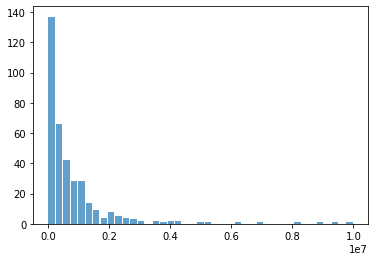

In [6]:
plt.hist(df['view'], bins='auto', alpha=0.7, rwidth=0.85)[2]

### Since it's heavily skewed, we apply a log transformation to it.

<a list of 20 Patch objects>

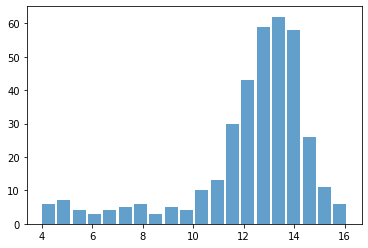

In [7]:
df['view_log'] = np.log(df['view'])
plt.hist(df['view_log'], bins='auto', alpha=0.7, rwidth=0.85)[2]

### Regression.

In [8]:
df2 = pd.concat([df.uploadtime, df.length, df.subscriber, df.iloc[:,11:51]], axis=1)
X = df2; Y = df['view_log']; X = sm.add_constant(X); X = X.astype(float)
model = sm.OLS(Y, X).fit()
#predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               view_log   R-squared:                       0.254
Model:                            OLS   Adj. R-squared:                  0.154
Method:                 Least Squares   F-statistic:                     2.543
Date:                Wed, 18 Mar 2020   Prob (F-statistic):           2.01e-06
Time:                        19:43:59   Log-Likelihood:                -792.28
No. Observations:                 365   AIC:                             1673.
Df Residuals:                     321   BIC:                             1844.
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          10.4265      0.864     12.064      0.000       8.726      12.127
uploadtime  -8.293e-05   3.01e-05     -2.752      0.006      -0.000   -2.36e-05
length      -1.033e-06    3.2e-06     -0.323      0.747   -7.34e-06    5.27e-06
subscriber   2.338e-07   3.87e-08      6.037      0.000    1.58e-07     3.1e-07
coronavirus     0.8791      0.855      1.028      0.305      -0.804       2.562
news            1.0767      0.727      1.480      0.140      -0.354       2.508
outbreak        0.5779      0.398      1.451      0.148      -0.206       1.362
china           0.2287      0.408      0.560      0.576      -0.575       1.032
trump           0.5825      0.610      0.955      0.340      -0.617       1.782
covid           0.2058      0.502      0.410      0.682      -0.783       1.194
case            0.3042      0.571      0.532      0.595      -0.820       1.428
u               0.0638      0.573      0.111      0.912      -1.064       1.192
death           0.3355      0.732      0.459      0.647      -1.104       1.775
italy          -0.5341      0.649     -0.822      0.411      -1.812       0.743
bbc            -0.5247      0.800     -0.655      0.513      -2.099       1.050
wuhan           0.2617      0.624      0.419      0.675      -0.967       1.490
update         -0.0937      0.636     -0.147      0.883      -1.345       1.157
spread         -0.6200      0.613     -1.011      0.313      -1.827       0.587
el              1.2401      0.685      1.810      0.071      -0.108       2.588
new            -0.1200      0.651     -0.184      0.854      -1.401       1.161
msnbc          -0.3691      0.717     -0.515      0.607      -1.780       1.042
response        0.3870      0.722      0.536      0.592      -1.033       1.807
virus          -0.2523      0.755     -0.334      0.738      -1.738       1.233
en              0.8730      0.753      1.160      0.247      -0.608       2.354
nbc            -0.3759      1.084     -0.347      0.729      -2.509       1.758
doctor          0.3003      0.754      0.398      0.691      -1.183       1.783
abc            -1.6472      1.077     -1.530      0.127      -3.766       0.471
symptom         0.2730      0.763      0.358      0.721      -1.228       1.774
people         -0.5394      0.812     -0.665      0.507      -2.136       1.057
disease        -0.7344      0.824     -0.892      0.373      -2.355       0.886
global          0.9052      0.818      1.107      0.269      -0.704       2.514
la              0.6836      0.895      0.764      0.445      -1.076       2.443
today           0.8357      0.865      0.966      0.335      -0.865       2.537
lockdown        0.6915      0.911      0.759      0.448      -1.100       2.483
quarantine      0.9020      0.888      1.016      0.310      -0.844       2.648
live           -0.5066      0.911     -0.55

## Answer and analysis: 
-As we see from the above results, the prediction for future views by linear regression model would be highly problematic and demonstrate lack-of-fit since the R square is only around 0.25. The relationship between the views and One-Hot-Encoded text may not be exactly linear. 

-Based on current model, only subscriber and upload time remain significant, which is reasonable. If a channel has larger number of subscribers and the video has indeed been uploaded for a longer time the expected number of viewers should be higher intuitively.

=====================================================================================================================


=====================================================================================================================
# Question 2. What are the key features of these titles by the method of PCA?

## - Question Description: 
PCA is a technique that create a new set of variables which are linear composites of the original variables.
We want to see if PCA could reveal some underlying patterns of those constructed features and at the same time achieve the purpose of dimension reduction.

## - Model: PCA

- Using the method of PCR and loss function of MSE, we can easily find that the top three PC are enough to yeild satisfying results.
- The shape and clustering of the first three componients are plotted as a summary.

In [9]:
#PCA
pca = PCA(n_components = 'mle')
X_reduced = pca.fit_transform(X)
X_reduced.shape
#Perform 10-fold cross-validation to see how PCR influences MSE.
n = len(X_reduced)
fold = model_selection.KFold(n_splits=10, shuffle=True, random_state=1)

model2 = LinearRegression(); mse = []    
mse.append(-model_selection.cross_val_score(model2, np.ones((n,1)), Y.ravel(), cv=fold, scoring='neg_mean_squared_error').mean())

for i in np.arange(1, 44):
    mse.append(-model_selection.cross_val_score(model2, X_reduced[:,:i], Y.ravel(), cv=fold, scoring='neg_mean_squared_error').mean())

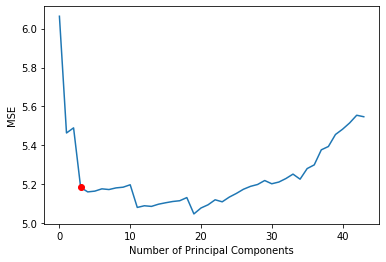

In [10]:
plt.plot(mse)
plt.xlabel('Number of Principal Components')
plt.ylabel('MSE')
plt.plot(3, mse[3], 'o', color = 'r')

### It's reasonable to choose n_components = 3.

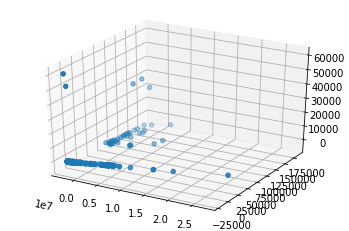

In [11]:
pca = PCA(n_components = 3)
X_pca = pca.fit_transform(X)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X_pca[:,0], X_pca[:,1], X_pca[:,2])

In [12]:
print (pd.DataFrame(pca.components_,columns=X.columns,index = ['PC-1','PC-2','PC-3']))

             const  uploadtime    length  subscriber   coronavirus  \
PC-1  9.054911e-18   -0.000136 -0.001434    0.999999  3.708338e-10   
PC-2 -5.248631e-17    0.022366  0.999749    0.001437 -6.163220e-07   
PC-3  5.830653e-17    0.999750 -0.022366    0.000104 -2.142624e-05   

              news      outbreak         china         trump         covid  \
PC-1  1.713152e-08  6.799196e-11 -7.051436e-09  8.765492e-09 -7.117962e-09   
PC-2 -4.502931e-07 -2.695990e-07  4.582790e-08  2.006392e-07  1.700825e-07   
PC-3 -1.698895e-06 -2.522336e-06 -2.243218e-06 -1.589085e-06 -2.485025e-06   

      ...    quarantine          live            de          toll  \
PC-1  ...  1.385860e-10 -2.656338e-09 -2.008917e-09  6.920370e-10   
PC-2  ... -1.808783e-07  7.863021e-07 -3.114608e-08 -1.734914e-07   
PC-3  ... -3.021404e-07  3.786603e-06 -4.743615e-07 -2.790792e-07   

             first      pandemic        expert          iran            dw  \
PC-1 -8.229784e-11 -1.238405e-09 -3.245702e-09  1.0

## Answer and analysis: 
- We have a high dimensional data X consists of original features like upload time and video length and word frequency constructed from video title.
After choosing 3 principle conponents, we can see two very strong 'line' patterns.  And the data are seperated into clear groups. Variables that are correlated with 3 first PC are the most important in explaining the variability in the data set. The rest of the data contribute less in helping exaplain the variability of the data.


=====================================================================================================================


=====================================================================================================================
# Question 3. If we can determine this video will be likeable/ What kind of video recommended to user tend to get positive feedback ?


## - Question Description: 

Based current data, we want to know what kind of videos with certain features will become popular among the audiences. It should also be a recommendation system problem, meaning that pushing what kinds of videos to the users tend to get positive feedback.

## - Model: Naive Bayes Text Classification
    
Here we defined a video as likeable by creating a binary classifier in two different ways. Firstly, by the method of odds ratios, when like/dislike ratio > a threshold, we classify it as 1 otherwise, 0. Secondly, by the method of log(mean), when log(mean) > a threshold, we classify it as 1 otherwise, 0. The choice of threshold should balance the data so the possible options are mean or median.



In [13]:
### The text here includes titles and channel names.
seed=2020
np.random.seed(seed)
df['all_text'] = df['clean_text'] + ' '+ df['channel']

### Approach 1. When like/dislike ratio > median, we classify this article as 1; otherwise, 0.

In [14]:
df['ratio'] = df['like']/df['dislike']
np.median(df['ratio'][np.isfinite(df['ratio'])])

11.923913043478262

In [15]:
df['classifier'] = df['ratio'].copy()
for i in range(df.shape[0]):
    if df['ratio'][i] > 12: df['classifier'][i] = 1
    else: df['classifier'][i] = 0

### Split the titles and classifiers into a training and test set using a 20% test split

In [16]:
texts_all = df['all_text'].values
labels_all = df['classifier'].values
train_texts, test_texts, train_labels, test_labels = train_test_split(texts_all, labels_all, test_size=0.2)
### Create `count`, `set` and `Tfidf` features using `CountVectorizer` and `TfidfVectorizer`.

count0 = CountVectorizer(input='content')
count1 = count0.fit_transform(train_texts)
count2 = count0.transform(test_texts)

set0 = CountVectorizer(input='content', binary=True)
set1 = set0.fit_transform(train_texts)
set2 = set0.transform(test_texts)

Tfidf0 = TfidfVectorizer(input='content')
Tfidf1 = Tfidf0.fit_transform(train_texts)
Tfidf2 = Tfidf0.transform(test_texts)

### Fit a `MultinomialNB` with smoothing $\alpha=1$ to the count features.

In [17]:
m0 = MultinomialNB(1)
m0.fit(count1, train_labels)
print('The predicition accuracy in the training set is:', np.mean(m0.predict(count1)==train_labels))

The predicition accuracy in the training set is: 0.928082191780822


### Use K-Fold validation with K=10 to select between multinomial Naive Bayes classifiers trained to either `set`, `count` and `tfidf` featues.

In [18]:
def model_cross_validation(model,X,y,folds):
    kfolds=len(folds)
    train_performance=np.empty(kfolds)
    validation_performance=np.empty(kfolds)
    for idx in range(kfolds):
        train,validation=folds[idx]
        X_train=X[train]
        y_train=y[train]
        model.fit(X_train,y_train)
        train_accuracy=np.average(model.predict(X_train)==y_train)
        X_validation=X[validation]
        y_validation=y[validation]
        validation_accuracy=np.average(model.predict(X_validation)==y_validation)
        train_performance[idx]=train_accuracy
        validation_performance[idx]=validation_accuracy
    return np.array(train_performance),np.array(validation_performance)

kf=KFold(10,shuffle=True)
folds=list(kf.split(set1))

In [19]:
t1, v1 = model_cross_validation(m0, set1, train_labels, folds)
# The accuracy of set features:
print("Train: ", np.mean(t1), "; Validation: ", np.mean(v1))

Train:  0.9360694279162918 ; Validation:  0.6394252873563219


In [20]:
t2, v2 = model_cross_validation(m0, count1, train_labels, folds)
# The accuracy of count features:
print("Train: ", np.mean(t2), "; Validation: ", np.mean(v2))

Train:  0.9284605114213565 ; Validation:  0.6670114942528735


In [21]:
t3, v3 = model_cross_validation(m0, Tfidf1, train_labels, folds)
# The accuracy of tfdif features:
print("Train: ", np.mean(t3), "; Validation: ", np.mean(v3))

Train:  0.9417801062316778 ; Validation:  0.6328735632183908


### The count features have the best accuracy.

### Therefore, we fit the best model to all the training data and compute its accuracy on the test set.

In [22]:
m0.fit(count1, train_labels)
print('The accuracy on the test set is:', np.mean(m0.predict(count2)==test_labels))

The accuracy on the test set is: 0.7397260273972602


### Approach 2. When log(view) > mean, we classify this article as 1; otherwise, 0.

In [23]:
np.median(df['view_log'][np.isfinite(df['view_log'])])

12.840000466430148

In [24]:
df['classifier2'] = df['view_log'].copy()
for i in range(df.shape[0]):
    if df['view_log'][i] > 12.84: df['classifier2'][i] = 1
    else: df['classifier2'][i] = 0

### Split the titles and classifiers into a training and test set using a 20% test split

In [25]:
texts_all = df['all_text'].values
labels2_all = df['classifier2'].values
train_texts, test_texts, train_labels2, test_labels2 = train_test_split(texts_all, labels2_all, test_size=0.2)

### Create `count`, `set` and `Tfidf` features using `CountVectorizer` and `TfidfVectorizer`.

In [26]:
count0_2 = CountVectorizer(input='content')
count1_2 = count0.fit_transform(train_texts)
count2_2 = count0.transform(test_texts)

set0_2 = CountVectorizer(input='content', binary=True)
set1_2 = set0.fit_transform(train_texts)
set2_2 = set0.transform(test_texts)

Tfidf0_2 = TfidfVectorizer(input='content')
Tfidf1_2 = Tfidf0.fit_transform(train_texts)
Tfidf2_2 = Tfidf0.transform(test_texts)

### Fit a `MultinomialNB` with smoothing $\alpha=1$ to the count features.

In [27]:
m1 = MultinomialNB(1)
m1.fit(count1_2, train_labels2)
print('The predicition accuracy in the training set is:', np.mean(m1.predict(count1_2)==train_labels2))

The predicition accuracy in the training set is: 0.9554794520547946


### Use K-Fold validation with K=10 to select between multinomial Naive Bayes classifiers trained to either `set`, `count` and `tfidf` featues.

In [28]:
kf=KFold(10,shuffle=True)
folds=list(kf.split(set1_2))

In [29]:
t1_2, v1_2 = model_cross_validation(m1, set1_2, train_labels2, folds)
# The accuracy of set features:
print("Train: ", np.mean(t1_2), "; Validation: ", np.mean(v1_2))

Train:  0.9661408295358894 ; Validation:  0.6268965517241379


In [30]:
t2_2, v2_2 = model_cross_validation(m1, count1_2, train_labels2, folds)
# The accuracy of count features:
print("Train: ", np.mean(t2_2), "; Validation: ", np.mean(v2_2))

Train:  0.9642338838417555 ; Validation:  0.640574712643678


In [31]:
t3_2, v3_2 = model_cross_validation(m1, Tfidf1_2, train_labels2, folds)
# The accuracy of tfdif features:
print("Train: ", np.mean(t3_2), "; Validation: ", np.mean(v3_2))

Train:  0.9699431109047107 ; Validation:  0.6573563218390805


### Therefore, we fit the best model to all the training data and compute its accuracy on the test set.

In [32]:
m1.fit(count1_2, train_labels2)
print('The accuracy on the test set is:', np.mean(m1.predict(count2_2)==test_labels2))

The accuracy on the test set is: 0.6027397260273972


## Answer and analysis: 

- By creating a binary classifier which determines if this video is likeable or nor, we build text classification model to make these kind of decision. Based on current data set, the performance of our model is satisfying and smooth since the accuracy for both models are around 70% .


=====================================================================================================================


=====================================================================================================================
# Question 4. What is the possible distribution of video length?

## - Question Description: 

For a specific user, we are interested in the possible distribution of the length of the video.

## - Model: 

Distribution fitting, test on goodness-of-fit and comparisons of QQ plot 


In [33]:
from sklearn import datasets
df = pd.read_csv('../data/video_clean.csv', index_col = 0)
y=df['length']
#removing outliers 
y = [a for a in y if a<3000]
y = np.array(y)
x = np.arange(len(y))
size = len(y)
#standardize 
sc=StandardScaler() 
yy = y.reshape(-1,1)
sc.fit(yy)
y_std =sc.transform(yy)
y_std = y_std.flatten()
y_std
del yy
import warnings
warnings.filterwarnings("ignore")
dist_names = ['beta','expon','gamma','lognorm','norm','pearson3','triang','uniform',
              'weibull_min',  'weibull_max','cauchy','invgamma','t']
chi_square = []
p_values = []
percentile_bins = np.linspace(0,100,51)
percentile_cutoffs = np.percentile(y_std, percentile_bins)
observed_frequency, bins = (np.histogram(y_std, bins=percentile_cutoffs))
cum_observed_frequency = np.cumsum(observed_frequency)
for distribution in dist_names:
    dist = getattr(scipy.stats, distribution)
    param = dist.fit(y_std)
    p = scipy.stats.kstest(y_std, distribution, args=param)[1]  
    p_values.append(p)    
    cdf_fitted = dist.cdf(percentile_cutoffs, *param[:-2], loc=param[-2], 
                          scale=param[-1])
    expected_frequency = []
    for bin in range(len(percentile_bins)-1):
        expected_cdf_area = cdf_fitted[bin+1] - cdf_fitted[bin]
        expected_frequency.append(expected_cdf_area)
    expected_frequency = np.array(expected_frequency) * size
    cum_expected_frequency = np.cumsum(expected_frequency)
    ss = sum (((cum_expected_frequency - cum_observed_frequency) ** 2) / cum_observed_frequency)
    chi_square.append(ss)        
results = pd.DataFrame()
results['Distribution'] = dist_names
results['chi_square'] = chi_square
results['p_value'] = p_values
results.sort_values(['chi_square'], inplace=True)
print ('\nDistributions sorted by goodness of fit:')
print ('----------------------------------------')
print (results)



Distributions sorted by goodness of fit:
----------------------------------------
   Distribution   chi_square        p_value
3       lognorm    18.181083   4.285423e-01
11     invgamma    24.603047   2.734863e-01
5      pearson3    29.735536   4.005400e-01
2         gamma    29.736381   4.006143e-01
0          beta    29.829565   3.998073e-01
8   weibull_min    57.113123   3.369444e-01
6        triang   309.422345   7.929741e-07
10       cauchy   344.907057   5.476972e-08
12            t   349.269635   9.732866e-04
4          norm   620.290666   2.611897e-04
1         expon   813.515869   5.445310e-07
7       uniform  1464.022026   1.884428e-38
9   weibull_max  5558.231134  6.364468e-128



Distribution parameters:
------------------------

Distribution: lognorm
Parameters: (5.026955625622792, 14.999999999963025, 3.6014609285321697)

Distribution: invgamma
Parameters: (4.427328504284321, -147.09276662440396, 2029.0260996300685)

Distribution: pearson3
Parameters: (1.428295509959585, 437.52660102664373, 305.35130275862923)


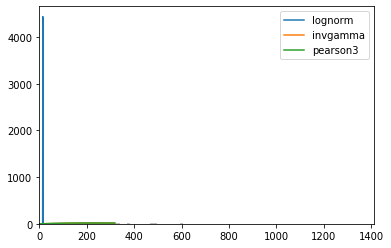

In [34]:
number_of_bins = 100
bin_cutoffs = np.linspace(np.percentile(y,0), np.percentile(y,99),number_of_bins)
h = plt.hist(y, bins = bin_cutoffs, color='0.75')
number_distributions_to_plot = 3
dist_names = results['Distribution'].iloc[0:number_distributions_to_plot]
parameters = []
for dist_name in dist_names:
    dist = getattr(scipy.stats, dist_name)
    param = dist.fit(y)
    parameters.append(param)
    pdf_fitted = dist.pdf(x, *param[:-2], loc=param[-2], scale=param[-1])
    scale_pdf = np.trapz (h[0], h[1][:-1]) / np.trapz (pdf_fitted, x)
    pdf_fitted *= scale_pdf
    plt.plot(pdf_fitted, label=dist_name)
    plt.xlim(0,np.percentile(y,99))
plt.legend()
#plt.show()

dist_parameters = pd.DataFrame()
dist_parameters['Distribution'] = (
        results['Distribution'].iloc[0:number_distributions_to_plot])
dist_parameters['Distribution parameters'] = parameters
print ('\nDistribution parameters:')
print ('------------------------')

for index, row in dist_parameters.iterrows():
    print ('\nDistribution:', row[0])
    print ('Parameters:', row[1] )

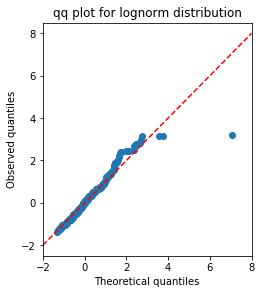

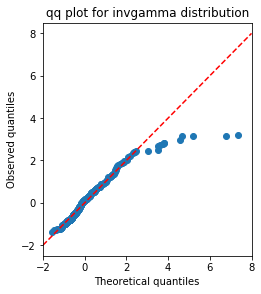

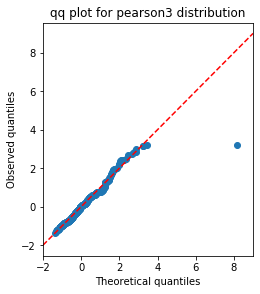

In [35]:
## qq plots
    
data = y_std.copy()
data.sort()
for distribution in dist_names:
    dist = getattr(scipy.stats, distribution)
    param = dist.fit(y_std)
    norm = dist.rvs(*param[0:-2],loc=param[-2], scale=param[-1],size = size)
    norm.sort()
    fig = plt.figure(figsize=(8,5)) 
    ax1 = fig.add_subplot(121) # Grid of 2x2, this is suplot 1
    ax1.plot(norm,data,"o")
    min_value = np.floor(min(min(norm),min(data)))
    max_value = np.ceil(max(max(norm),max(data)))
    ax1.plot([min_value,max_value],[min_value,max_value],'r--')
    ax1.set_xlim(min_value,max_value)
    ax1.set_xlabel('Theoretical quantiles')
    ax1.set_ylabel('Observed quantiles')
    title = 'qq plot for ' + distribution +' distribution'
    ax1.set_title(title)
    # Display plot    
    plt.tight_layout(pad=4)
    plt.show()

## Answer and analysis: 

Based on the result from both goodness of fit test there are three possible options for the distribution: Pearson Type 3, Beta and inverse Gamma distribution. From the result of QQ plot, we see that Pearson Type 3 demonstrate the most fitting properties. 


=====================================================================================================================


=====================================================================================================================
# Question 5. Can we classify videos through sentiments? 

## - Question Description: 

Users' preference to watch some of the uploaded videos depends on how the title of video was worded. Uploaders want to enclose enough key words to for the search engine to capture. Some videos are highly sentimental that allures people to click on and watch. We want to see if we can classify the title of the videos by sentiments.

## - Model:
We use naive classification on the `compound` scores derived from the polarity scores based on the elements in the titles.

In [36]:
data=df
sia = SIA()
results = []

for line in data['title'].values.copy():
    pol_score = sia.polarity_scores(line)
    pol_score['headline'] = line
    results.append(pol_score)

In [37]:
data_polar = pd.DataFrame.from_records(results)
data['neg'] = data_polar.neg
data['neu']= data_polar.neu
data['pos']= data_polar.pos
data['compound']= data_polar['compound']
data.head()

,title,view,channel,uploadtime,length,link,subscriber,like,dislike,clean_text,neg,neu,pos,compound
0,Unprecedented restrictions in Italy over coron...,22000,CNN,3,498,https://www.youtube.com/watch?v=v_vDjR5zBDk,8710000,735,124,unprecedented restriction italy coronavirus ou...,0.0,1.000,0.000,0.0000
1,New York reels with largest coronavirus outbre...,264000,ABC News,11,237,https://www.youtube.com/watch?v=7JedXOgOPC8,7860000,2082,223,new york reel largest coronavirus outbreak u wnt,0.0,1.000,0.000,0.0000
2,Trump urges calm at coronavirus task force bri...,442000,CBS News,10,351,https://www.youtube.com/watch?v=zSfbAP3emSE,2390000,2610,2208,trump urge calm coronavirus task force briefing,0.0,0.753,0.247,0.3182
3,Governor Cuomo Gives Updates On Coronavirus In...,98000,MSNBC,14,336,https://www.youtube.com/watch?v=06Q1CQd33zM,2420000,711,253,governor cuomo give update coronavirus new yor...,0.0,1.000,0.000,0.0000
4,Coronavirus: Cruise Ship Carrying People With ...,209000,NBC News,10,814,https://www.youtube.com/watch?v=sku3zWvLXnM,1960000,919,101,coronavirus cruise ship carrying people corona...,0.0,1.000,0.000,0.0000


### Calculating Polarity Scores

New four columns from the sentiment scoring: `neu`, `neg`, `pos` and `compound` are generated. The first three represent the sentiment score percentage of each category in the video `title`, and the `compound` is a single sentiment score that ranges from -1 (Extremely Negative) to 1 (Extremely Positive).

Since the virus is spreading in the west hemisphere and is covered more in the media, we might get more bad news in the search results. Adding the neutrality of mass media posts, it is rare to find title with obvious positive sentiments.  

### Classification by Compound
 
`Label`s are created based on the `compound`. We consider titles with a compound > 0.4 as positive (denoted as `1`) and < -0.5 as negative (denoted as `-1`), other situation will be assigned a `0` as neutural. The cutoff is determined by trying several numbers. If the threshold has a higher absloute value, we might get fewer false positives and false negatives, but the size of the results with true negatives and true positives will drop drastically.

In [38]:
data['label'] = 0
data.loc[data['compound'] > 0.4, 'label'] = 1
data.loc[data['compound'] < -0.5 , 'label'] = -1
data[['title','compound','neg','neu','pos','compound','label']].head()

,title,compound,neg,neu,pos,compound,label
0,Unprecedented restrictions in Italy over coron...,0.0000,0.0,1.000,0.000,0.0000,0
1,New York reels with largest coronavirus outbre...,0.0000,0.0,1.000,0.000,0.0000,0
2,Trump urges calm at coronavirus task force bri...,0.3182,0.0,0.753,0.247,0.3182,0
3,Governor Cuomo Gives Updates On Coronavirus In...,0.0000,0.0,1.000,0.000,0.0000,0
4,Coronavirus: Cruise Ship Carrying People With ...,0.0000,0.0,1.000,0.000,0.0000,0


### Comparing Sentiments and Likes
Three ratios are generated:

Likes to all emotion expressions, as `like_ratio1`;\
Likes to total views, as `like_ratio2`;\
Dislikes to total views, as `like_ratio3`;

In [39]:
data['like_ratio1'] = data['like']/(data['like']+data['dislike'])
data['like_ratio2'] = data['like']/(data['view'])
data['like_ratio3'] = data['dislike']/(data['view'])

Lots of the compounds has 0 value, so we look at other compounds different from 0 and the ratios

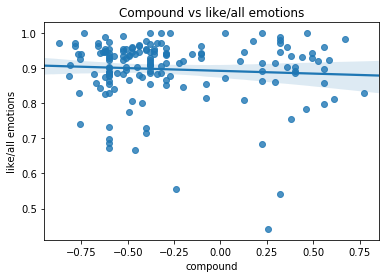

In [40]:
cl1 = sns.regplot(x=data['compound'][data['compound']!=0], y=data['like_ratio1'][data['compound']!=0])
cl1.set_title('Compound vs like/all emotions')
cl1.set_ylabel('like/all emotions')
plt.show(cl1)

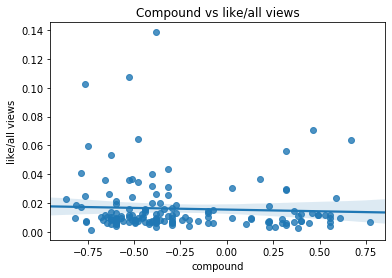

In [41]:
cl2 = sns.regplot(x=data['compound'][data['compound']!=0], y=data['like_ratio2'][data['compound']!=0])
cl2.set_title('Compound vs like/all views')
cl2.set_ylabel('like/all views')
plt.show(cl2)

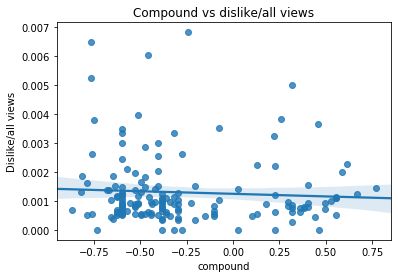

In [42]:
cl3 = sns.regplot(x=data['compound'][data['compound']!=0], y=data['like_ratio3'][data['compound']!=0])
cl3.set_title('Compound vs dislike/all views')
cl3.set_ylabel('Dislike/all views')
plt.show(cl3)

Likes and dislikes might be uncorrelated with the compound.

### Verification and Doubts

We then look into some titles of videos with positive or negative sentiments.

In [43]:
print("\"Positive\" headlines:\n")
print(list(data[data['label'] == 1].title)[:5])

print("\nNegative headlines:\n")
print(list(data[data['label'] == -1].title)[:5])

"Positive" headlines:

['Watch live: D.C. mayor updates on coronavirus after first positive case', 'Is Italy’s Massive Coronavirus Quarantine Sign Of Things To Come? | AM Joy | MSNBC', '21 people aboard Grand Princess cruise ship test positive for coronavirus: Pence | ABC News', 'ABC News Prime: Coronavirus global spread, Grand Princess cruise ship, Market meltdown', 'Trump Praises Coronavirus Response As Cases Rack Up And Markets Spiral | The 11th Hour | MSNBC']

Negative headlines:

['Coronavirus death toll rises in Italy to 366 as quarter of population on lockdown | ITV News', 'Coronavirus Threat: To The Economy, And The Presidency | The Day That Was | MSNBC', 'First UK Coronavirus death in Berkshire - BBC NEWS', "Italy's coronavirus outbreak sparks 'a lot of panic", 'At least 12 dead, 188 infected in US as coronavirus continues to spread | Nightline']


Negative headlines approximately had the right sentimental classification, but the positive headlines are not. “Positive” diagnosis of COVID-19 was count as positive sentiment and caused biases. It is possible to check how many titles are affected.


In [44]:
data[data['title'].str.contains('positive', case=False)]['title'].values

array(['Watch live: D.C. mayor updates on coronavirus after first positive case',
       '21 people aboard Grand Princess cruise ship test positive for coronavirus: Pence | ABC News',
       'Coronavirus: Half of California cruise passengers test positive | Nine News Australia',
       'He tested positive for coronavirus.  Hear how he feels now',
       "Coronavirus: Iran's deputy health minister tests positive as outbreak worsens - BBC News"],
      dtype=object)

All observations subsetted matched the situation described above. Then we filter out these observations to see titles of somewhat "positive" sentiments.

In [45]:
data[data['title'].str.contains('positive', case=False) == False][data['label'] == 1]['title'].values

array(['Is Italy’s Massive Coronavirus Quarantine Sign Of Things To Come? | AM Joy | MSNBC',
       'ABC News Prime: Coronavirus global spread, Grand Princess cruise ship, Market meltdown',
       'Trump Praises Coronavirus Response As Cases Rack Up And Markets Spiral | The 11th Hour | MSNBC',
       'Coronavirus outbreak claims lives of more than a dozen Life Care Center residents',
       "Coronavirus: Countries need to 'help each other' as deaths increase - BBC Newsnight",
       'Coronavirus: doctors and nurses in Iran filmed dancing in bid to boost morale',
       'Coronavirus whistleblower doctor is online hero in China',
       'Coronavirus: Worst-hit countries boost containment efforts - BBC News',
       'What is the coronavirus? Everything you need to know about symptoms, how to stay safe and what next',
       'China को मिल गयी Coronavirus की Medicine ?  | Tez Special Report',
       'Coronavirus prevention: how to make your own hand sanitizer',
       'NOVEL CORONAVIRUS(201

## Analysis: 

We want to ignore some data points with other language that our team does not understand (such as Spanish).\
Good news do not necessarily have good sentiments revealed in the title. The titles are mostly providing information hence they are usually neutural.\
Those titles are short and concise for viewers to know most of the information, so they are in fact neutral most of the time. For the natural language processing, we want more significant and informative tokens or keywords. Titles may not be a good object for sentimental analysis.\
The default sentiment tools in the `nltk` package might not be helpful here for video titles. The dictionary needs to be trained in the context of outbreak of coronavirus. Also, we may want to look at comments in each video, which are more suitable for sentimental tools.

=====================================================================================================================


=====================================================================================================================
# Question 6. Can we separate all videos into different types? 

## - Question Description: 

Many kinds of video posts will be provided through YouTube videos. For example, news can be separated in different types, suchj as vlogs, politics, economics, public health, etc. We wonder if it is possible to separate type of videos only through the elements in the titles. 

## - Model

There is no actual labels for the original data. Meanwhile, youtube did not set up sub-areas (like a sub-folder) to tag and classify those videos. We have to use unsupervised learning algorithms. Here we ultilize the k-means clustering trying to cluster all those titles into different categories. 

### Training

Before performing clustering, we vectorize and process the cleaned tokens into term frequency-inverse document frequency (tf-idf), a creteria of importance of a word in the text.

The training set we use is the search results scraped on March 10.

In [46]:
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['clean_text'].copy().values)

Here we preload the search results scraped on March 14, plus uploaded within 24 hours (exclusive) to verify the results of clustering. These videos titles are clearly not included in the training set.

In [47]:
ver = pd.read_csv('../data/video_clean2.csv', index_col = 0)
ver = ver[ver['uploadtime']<24].copy()

It is difficult to determine the number of k. Here we use 3 as an example.

In [48]:
k = 3
model = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1)
model.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
       n_clusters=3, n_init=1, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [52]:
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
feature_name = vectorizer.get_feature_names()

### Guessing Cluster Characteristics
Here we check the first eight main tokens (feature) in each cluster to see(guess) what the cluster is about.


In [53]:
for i in range(k):
    print('Cluster', i),
    for j in order_centroids[i, :8]:
        print('%s' % feature_name[j])

Cluster 0
case
trump
coronavirus
msnbc
response
death
news
confirmed
Cluster 1
coronavirus
news
china
covid
el
spread
wuhan
bbc
Cluster 2
outbreak
coronavirus
china
italy
contain
news
new
covid


We tried to guess what might be included in the cluster. 
For example, 'Trump' in cluster 0. It is possible that news about president's speech or somebody will be included in this cluster.\
In cluster 1, we saw "COVID" and "China". We guess China related news will be included in this cluster.\
In cluster 2, we saw "Italy".

However, characteristics of three clusters had strong overlapping and was not clear. For example, "Coronavirus" is observed in all clusters. So as "China" and "News". Given the homogeneous property of video titles, it is possible the classification model may not work well.

### Verification

In [54]:
pd.options.display.max_colwidth = 100
YY = vectorizer.transform(ver['clean_text'].copy().values)
predicted = model.predict(YY)
ver['pred'] = predicted
ver[['title','pred','uploadtime']]

,title,pred,uploadtime
0,Europe becomes new coronavirus epicenter,1,8
1,WATCH LIVE: Trump gives coronavirus update,0,1
2,Infection Rate Charts Forecast Steep Rise In US Coronavirus Cases | Rachel Maddow | MSNBC,0,15
3,Iran is building a massive grave for coronavirus victims,1,22
4,Trump declares national emergency to combat coronavirus,0,22
5,Miami mayor who tested positive for coronavirus speaks on quarantine experience,1,18
6,Coronavirus: Europe at the epicentre of the pandemic - BBC News,1,22
10,What happens if the homeless population gets infected with coronavirus?,1,19
28,Coronavirus outbreak: B.C. health officials confirm 11 new cases of COVID-19,2,22
31,Coronavirus: What Powers The Government Can Use To Stop The Spread | NBC Nightly News,1,21


### Results

After running prediction for several times, we noticed the results of the prediction model are fragile.\
For video titles including "Trump" or some people's names were in one cluster, but sometimes they were predicted as other clusters that exclude "Trump". This cluster happened but not always catch this characteristics. 

The result is not ideal. Also, the result is unbalanced since one cluster had most of the titles, but the other two had only a few of the titles.

Below we calculate the Silhouette Score to see if the clusters are strongly overlapped.

In [55]:
round(silhouette_score(YY, labels=model.predict(YY)),4)

0.0231

## Analysis: 

It is hard to perform unsupervised k-means clustering on the titles of the videos because the features of the titles are highly overlapped. This is seen from the classification results and the near-0 silhouette score. Also, the verification set is imbalanced because many of the titles did include the word "Trump" which is related to some announcement or decisions made by the president. 

Also, video titles are different from people's comments or a section of passage from texts. The number of words is few in those titles and the contents are highly brief. This also made the classification difficult.

If we really want to perform such classification, we can:
* Tune the parameters using other attributes or methods
* Include more attibutes such as descriptions or comments
* Use alternative classification models
 


=====================================================================================================================
